## Imputation of Johan Sverdrups Well Log and the Seismogram

Norwegian Petroleum Directorate ([NPD Factpage](https://factpages.npd.no/en/wellbore/pageview/exploration/all/6374)) publised the well log from well 16/2-6 in Johan Sverdrups oil field on 16.10.2012. Geolink-S2 ([Geolink](https://www.geolink-s2.com/)) donated the lithology interprettion of the well log with the 'cc-by-4.0' license, which comes along with this notebook. Both logs have missing data in it, which makes it inconvenient for quantative analysis. 

The purpose of this Jupyter Notebook is to provide an algorithm of imputing the misssing data in the well logs. The log provided by Geolink was used, because it contains less missing data. As an example of quantative analysis, a synthetic seismogram based on the imputed well log was derived.

## 1- Data Loading and Iterative Imputation of Missing Data

In [1]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 1.1- Import Well Log & Imputation of Missing Values

In [2]:
# import the well log
w_las= lasio.read(r'JS16_2-6_Geolink.las')
# w_las.header # check well log header

In [3]:
# fill in missing values using imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

wdf = w_las.df()  # convert well log to dataframe to enable tools in Pandas
imputer = IterativeImputer(missing_values=np.nan, max_iter=100)
imputer.fit(wdf) 
df = imputer.transform(wdf) 

df = pd.DataFrame(df, columns = wdf.columns, index=wdf.index) # retain column names
df['LITHOLOGY_GEOLINK'] = wdf['LITHOLOGY_GEOLINK'] # retain interpretation from Geolink

# df.to_csv('well_data_imputed.csv',index=True) # output to a file for QC

#### 1.2-  QC plot of Imputed Data

In [4]:
def QC_plot(feat_orig, feat_imp):
    f1 = feat_orig.copy()
    f2 = feat_imp.copy()

    fig, axs = plt.subplots(1, 2, sharey=True, figsize = (6,12), gridspec_kw={'width_ratios': [1,1]})
    fig.subplots_adjust(wspace=0.1)
    # -----------------------------------------------------------------------------------track1------------
    axs[0].plot(f1, f1.index,'k', alpha = 0.8)
    axs[0].set_title('Original', style = 'normal')
    axs[0].invert_yaxis()
    axs[0].grid()
    # -----------------------------------------------------------------------------------track2------------
    axs[1].plot(f2, f2.index,'b', alpha = 0.8)
    axs[1].set_title('Imputed', style = 'normal')
    axs[1].invert_yaxis()
    axs[1].grid()

In [5]:
QC_plot(wdf.RHOB, df.RHOB)  # uncomment for comparison of any features before/after imputation
# QC_plot(wdf.DTC, df.DTC)

## 2- Synthetic Seismogram using the Imputated Well Log

### 2.1- Time-Depth Relationship (TDR)

The sonic log 'DTC' records the slowness of the wave traveling in the rocks. Intergrating the sonic log over the traveled depth gives the tavel time of the waves. In order to tie the well in depth/time from the sea mirror, a remedy of the water column and upper part of the well, including the rotation Kelly Bushing was derived using a replace velocity of 1900 m/s, the time was added to the top of the integrated traveling time.

In [6]:
water_depth = 115            # water column depth
log_start = 735.07409668     # Depth of logging start(m)
kb = 26                      # Kelly Bushing elevation(m) from NPD site, missing in well log header

In [7]:
water_vel = 1486             # accoustic velocity in water
gap_int = log_start - kb
repl_vel = 1900              # computed by comparing seismogram and tops of well
log_start_time = 2.0*water_depth/water_vel + 2.0*kb/repl_vel + 2.0 * gap_int / repl_vel        # TWT, unit s

In [8]:
t_cum =  np.cumsum(df['DTC'] ) / 1e6 # unit s
df['TWT'] = t_cum + log_start_time
# df.describe()

### 2.2 - Acoustic Impedance and Reflection coefficients

Accoustic Impedance (AI) is a feature of rockes, the discontinuity of AI between rock layers causes reflection of seismic waves. AI is defines as the production of the density and sonic velocity of the medium. Nomally, before the calculation of AI, the density and sonic logs needs to be smoothed and sometimes de-spiked, when necessary.

#### Well log Smoothing

In [9]:
def z_scores(feat):  
    ftr = feat.copy()
    
    ftr['median']= ftr.median()
    ftr['mad'] = abs(ftr- ftr['median']).median()  
    zscores = (ftr - ftr['median']) / ftr['mad']
    
    return zscores

In [10]:
def featr_smooth(feat, lop=5):
    ftr = feat.copy()
    for i in np.arange(len(ftr)):
        w = np.intersect1d(np.arange(i-lop,i+1+lop), np.arange(len(ftr)))
        ftr[i] = np.mean(feat.iloc[w])
    return ftr 

In [11]:
#Sonic Smoothing
df['DT_SM'] = featr_smooth(df['DTC'], 7)

#Density Smoothing
df['RHOB_SM'] = featr_smooth(df['RHOB'], 7)

#### Accoustic Impednce

In [12]:
# Sonic velocity is the reciprocal of slowness DT_SM
df['Vsonic'] = 1./df['DT_SM']                

In [13]:
# AI defined as product of density and sonic velocity
df['AI'] = df['Vsonic'] * df['RHOB_SM']       

#### Reflection Coefficient Series (Rc)

In [14]:
Imp = df['AI'].values
Rc=[]
for i in range(len(Imp)-1):
    Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

Rc.append(Rc[-1]) # end appending

In [15]:
# Paste Rc into dataframe as new column
df['Rc'] = pd.Series(Rc, index=df.index)

### 2.3-Convolutional Model and the Seismogram

Synthetic seismogram will be generated based on the convolutional model, which states: the synthetic seismogram is the convolution of a wavelet and the Rc. The calculation is performed in time domain, for this time domain wavelet and Rc are needed.
Rc in the time domain was calculated from AI, which is resampled from depth domain to time domain.

#### Resampling to Time Domain

In [16]:
dt = 0.001   #sampleing interval
t_max = 3.0   # max time to create time series
t = np.arange(0, t_max, dt)
AI_tdom = np.interp(x=t, xp = df.TWT, fp = df.AI)    # AI resampling in time 

In [17]:
# Rc in time domain
Rc_tdom = []
for i in range(len(AI_tdom)-1):
    Rc_tdom.append((AI_tdom[i+1]-AI_tdom[i])/(AI_tdom[i]+AI_tdom[i+1]))

Rc_tdom.append(Rc_tdom[-1]) # tail appending
# Rc_tdom

#### Ricker Wavelet and the Synthetic Seismogram (Convolution Model)

In [18]:
from bruges.filters import ricker

In [19]:
duration = 0.512
# dt = 0.001   # sampleing interval
f = 40 
rw , rt= ricker(duration, dt, f, return_t = True, sym=True)

# Synthetic Seismogram by Convolutioan model
synthetic = np.convolve(rw, Rc_tdom, mode='same')

## 3- Visualization

#### Formation Tops 

A formation is a body of strata of predominantly one type or combination of types, the start point of one formtaion is its "top". Tops are the points where geological discontinuities and AI contrasts appear, which will lead to reflections of seismic waves. It is thus important for interpretation.
Tops are usaully saved in a file. In the following the tops will be read in and converted to a dictionary for forther use.

In [20]:
df_top = pd.read_csv('JS16_2-6_Tops.csv') # read from csv file into dataframe
tops_dept = dict(df_top.values.tolist())  # convert to dictionary

In the following the depths of tops will be mapped on to the nearest depth indexes in the measured depth (MD) in well log, the corresponding TWT will be read from the integrated df['TWT'] or df.TWT using the indexes.

In [21]:
def nearest_value(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [22]:
TWT=df.TWT.values
tops_twt={} # dictionary for the TWT of tops 
for key, val in tops_dept.items():
    tops_twt[key]=TWT[nearest_value(df.index, val)]

#### Figure 1: depth domian plotting

Tops, well logs (smoothed density and sonic), acoustic impedance, reflection coefficients and time-depth relation in depth domain.

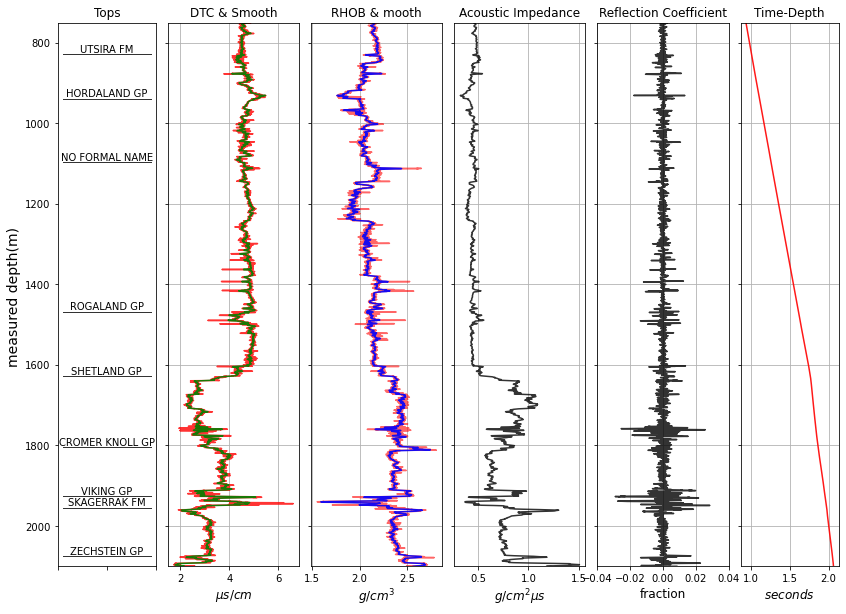

In [23]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize = (14,10), gridspec_kw={'width_ratios': [1.5,2,2,2,2,1.5]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('measured depth(m) ', fontsize = '14' )
axs[0].set_xticklabels('')
for Top in tops_dept.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, MD in tops_dept.items():
    axs[0].text( x = 0.5,  y = float(MD), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( df.DTC/30.48, df.index,'r', alpha=0.8) # convert us/ft -> us/30.48cm, for plotting only
axs[1].plot( df.DT_SM/30.48, df.index,'g', alpha=0.9)  # convert us/ft -> us/30.48cm, for plotting only
axs[1].set_title('DTC & Smooth', style = 'normal')
axs[1].set_xlabel( r'$\mu s/cm $', fontsize = '12')
axs[1].set_ylim(750, 2100)
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( df.RHOB, df.index,'r', alpha=0.6)
axs[2].plot( df.RHOB_SM, df.index,'b', alpha=0.9)
axs[2].set_title('RHOB & mooth', style = 'normal')
axs[2].set_xlabel('$g/cm^3$', fontsize = '12')
axs[1].set_ylim(750, 2100)
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------  
axs[3].plot( df.AI*30.48, df.index,'k', alpha=0.8) # convert ft/us -> 30.48 cm/us, for plotting only
axs[3].set_title('Acoustic Impedance', style = 'normal')
axs[3].set_xlabel( r'$g/cm^2\mu s$', fontsize = '12')
axs[1].set_ylim(750, 2100)
axs[3].invert_yaxis()
axs[3].grid()
# -----------------------------------------------------------------------------------track5-----------
axs[4].plot( df.Rc, df.index,'k', alpha=0.8)
axs[4].set_title('Reflection Coefficient', style = 'normal')
axs[4].set_xlabel('fraction' , fontsize = '12')
axs[1].set_ylim(750, 2100)
axs[4].set_xlim(-0.04, 0.04)
axs[4].invert_yaxis()
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
axs[5].plot( df.TWT, df.index,'r', alpha=0.9)
axs[5].set_title('Time-Depth', style = 'normal')
axs[5].set_xlabel( '$seconds$', fontsize = '12')
axs[1].set_ylim(750, 2100)
axs[5].invert_yaxis()
axs[5].grid()
plt.savefig('Fig1.png', dpi=300)

#### Figure 2: time domain plotting

Tops, acoustic impedance, reflection coefficients, Ricker wavelet and the synthetic sesimogram.

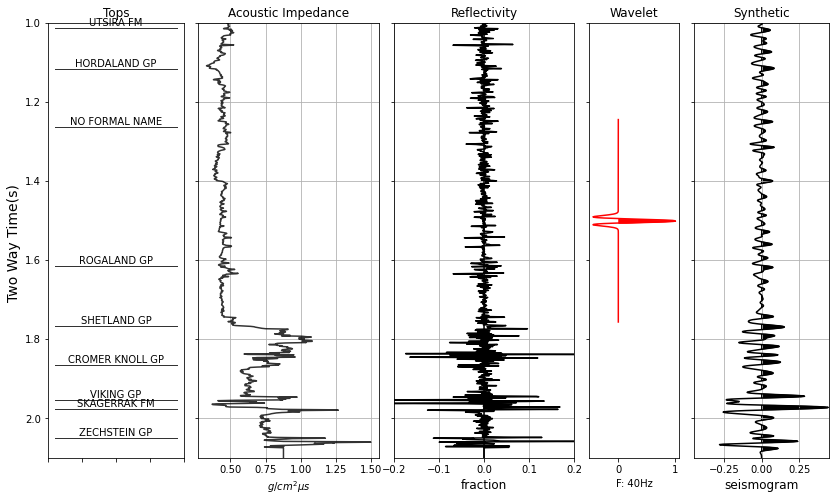

In [24]:
fig, axs = plt.subplots(1, 5, sharey=False, figsize = (14,8), gridspec_kw={'width_ratios': [1.5,2,2,1,1.5]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('Two Way Time(s) ', fontsize = '14' )
axs[0].set_xticklabels('')
axs[0].set_ylim(1.0 , 2.1)
axs[0].invert_yaxis()

for Top in tops_twt.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[0].text( x = 0.5,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( AI_tdom*30.48, t,'k', alpha=0.8)  # convert ft/us -> 30.48 cm/us, for plotting only
axs[1].set_title('Acoustic Impedance', style = 'normal')
axs[1].set_xlabel( r'$g/cm^2\mu s$', fontsize = '10')
axs[1].set_ylim(1.0 , 2.1)
axs[1].set_yticklabels('')
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( Rc_tdom, t,'k')
axs[2].plot([0, 0], [t.min(), t.max()], '-', c='k')
axs[2].set_title('Reflectivity', style = 'normal')
axs[2].set_xlabel('fraction' , fontsize = '12')
axs[2].set_ylim(1.0 , 2.1)
axs[2].set_xlim(-0.2 , 0.2)
axs[2].set_yticklabels('')
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------   
axs[3].plot( rw, rt + 1.5, 'r', alpha=0.99)
axs[3].fill_betweenx(rt + 1.5, rw,  0, rw > 0.0,  color='r')
axs[3].set_title('Wavelet', style = 'normal')
axs[3].set_xlabel('F: '+ str(f)+'Hz' , fontsize = '10')
axs[3].set_yticklabels('')
axs[3].set_ylim(1.0 , 2.1)
axs[3].invert_yaxis()
# -----------------------------------------------------------------------------------track5------------
axs[4].plot( synthetic, t ,'k')
axs[4].fill_betweenx(t, synthetic,  0,  synthetic > 0,  color='k')
axs[4].set_title('Synthetic', style = 'normal')
axs[4].set_xlabel('seismogram' , fontsize = '12')
axs[4].set_ylim(1.0 , 2.1)
axs[4].set_xlim(-0.45 , 0.45)
axs[4].invert_yaxis()
axs[4].set_yticklabels('')
axs[4].grid()

plt.savefig('Fig2.png', dpi=600)

## Remarks

1. the replace velocity in the top part of the well was derived by a comparison of the computed TWT with the one from the well log. <br>
2. the imputation method runs fast and provides reasonable estimation of the missing data in each feature of the well log (except the data at the beginning and the end, due to boundary effect), though, as an example, only the imputed density and sonic logs were used to derive the seismogram.  <br>

### Refrences:<br>
[Ryan A. Mardani: Generating Synthetic Seismogram in Python](https://towardsdatascience.com/generating-synthetic-seismogram-in-python-519f23f07894) <br>
[Darren A. Whitaker & Kevin Hayes: A simple algorithm for despiking Raman spectra](https://www.sciencedirect.com/science/article/abs/pii/S0169743918301758) <br>
[Evan Bianco, SEG Tutroial: Wavelet estimation for well ties](https://wiki.seg.org/wiki/Wavelet_estimation_for_well_ties) <br>
[SEG WiKI: Well tie calculus](https://wiki.seg.org/wiki/Well_tie_calculus) <br>